In [1]:
#!pip install transformers torch torchvision
#!pip install opencv-python pandas rapidfuzz
#!pip install pandas fuzzywuzzy python-Levenshtein

import torch
#!pip install --quiet easyocr
import easyocr
import cv2
import pandas as pd
import re
import matplotlib.pyplot as plt
from PIL import Image
from rapidfuzz import process, fuzz
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

c:\Users\Yassine Ben MAKTOUF\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Chargement de TrOCR pré-entraîné
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> i

Using CPU. Note: This module is much faster with a GPU.


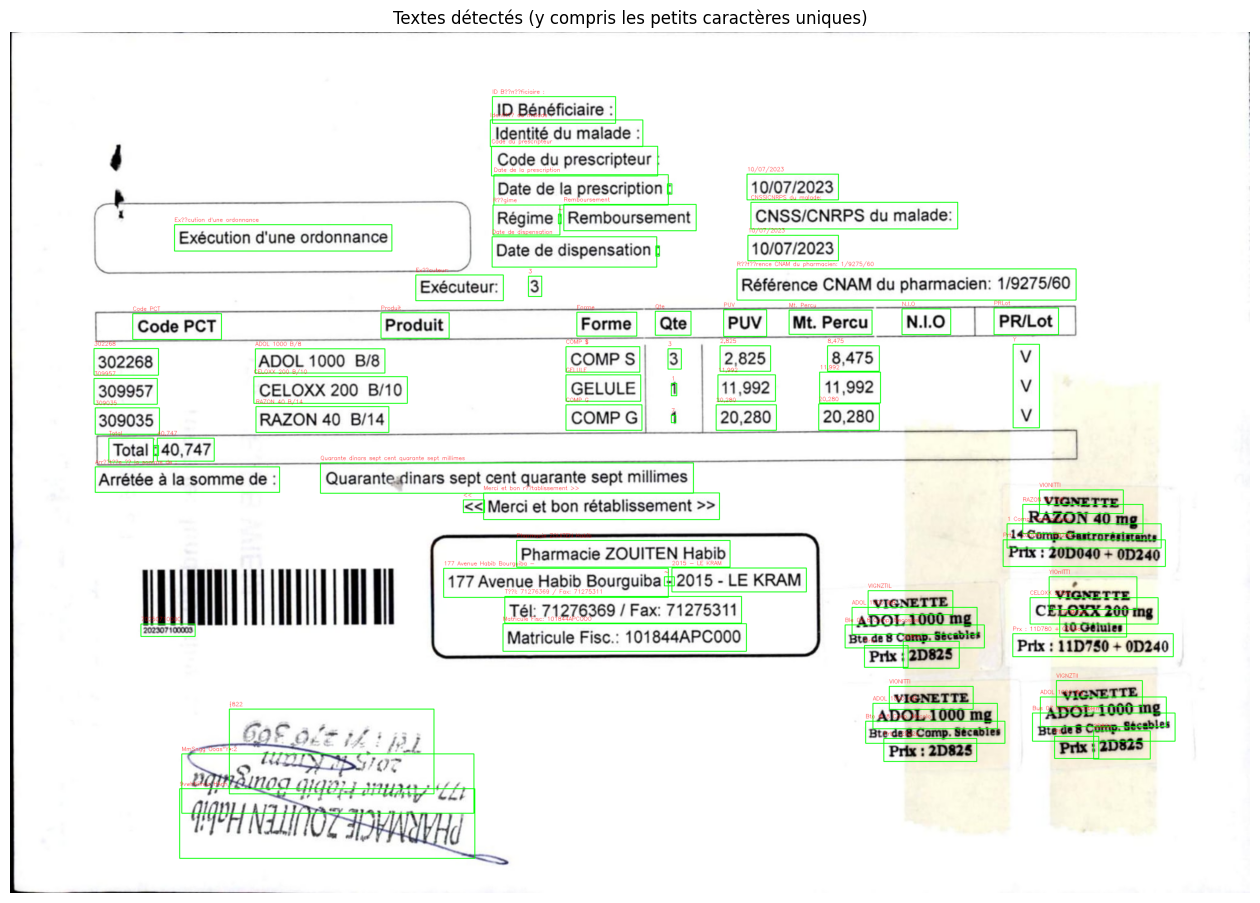

In [3]:
import cv2
import re
import easyocr
import matplotlib.pyplot as plt

# Fonction pour détecter si le texte contient des caractères arabes
def contains_arabic(text):
    return bool(re.search(r'[\u0600-\u06FF\u0750-\u077F]', text))

# 1) Charger l'image
image_path = "facture 1.jpg"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image introuvable à {image_path}")

# 2) Agrandir l'image pour mieux détecter les petits caractères
scale_percent = 200  # doubler la taille pour mieux capter les petits chiffres/lettres
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
image = cv2.resize(image, dim, interpolation=cv2.INTER_CUBIC)

# 3) Convertir en niveaux de gris
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 4) Seuillage (optionnel, pour améliorer contraste si besoin)
thresh = cv2.threshold(
    gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)[1]

# 5) OCR avec EasyOCR
reader = easyocr.Reader(['en', 'fr'], gpu=False)
results = reader.readtext(thresh, detail=1, paragraph=False, text_threshold=0.3, low_text=0.2, link_threshold=0.3)

# 6) Dessiner les boîtes uniquement pour texte non arabe
for bbox, text, prob in results:
    if contains_arabic(text):
        continue  # Ignorer le texte en arabe

    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    br = (int(br[0]), int(br[1]))
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)

    # Afficher aussi le texte reconnu pour vérifier
    cv2.putText(
        image, text, (tl[0], tl[1] - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1
    )

# 7) Afficher l'image avec les textes filtrés
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16, 12))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Textes détectés (y compris les petits caractères uniques)")
plt.show()


In [4]:
import csv

# Initialisation des fichiers
txt_lines = []
csv_lines = [("ligne", "texte", "bbox")]

for idx, (bbox, text, prob) in enumerate(results):
    if contains_arabic(text):
        continue  # Ignore textes arabes

    # --- Découpe image
    x_min = int(min([pt[0] for pt in bbox]))
    y_min = int(min([pt[1] for pt in bbox]))
    x_max = int(max([pt[0] for pt in bbox]))
    y_max = int(max([pt[1] for pt in bbox]))
    cropped = image[y_min:y_max, x_min:x_max]

    # --- Passage à PIL pour TrOCR
    pil_img = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    inputs = processor(images=pil_img, return_tensors="pt").pixel_values.to(model.device)
    generated_ids = model.generate(inputs)
    trocr_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # --- Affichage et collecte
    print(f"Ligne {idx+1} : {trocr_text}")
    txt_lines.append(trocr_text)
    csv_lines.append((idx + 1, trocr_text, str(bbox)))

# === Écriture .txt
with open("extraction_trocr.txt", "w", encoding="utf-8") as f_txt:
    for line in txt_lines:
        f_txt.write(line + "\n")

# === Écriture .csv
with open("extraction_trocr.csv", "w", encoding="utf-8", newline='') as f_csv:
    writer = csv.writer(f_csv)
    writer.writerows(csv_lines)

print("✅ Export terminé : extraction_trocr.txt & extraction_trocr.csv")


Ligne 1 : ID BENEFICIAIRE :
Ligne 2 : IDENTITE QU MALADE :
Ligne 3 : CODE QU PRESCRIPTEUR
Ligne 4 : DATE DE IA PRESCRIPTION
Ligne 5 : :
Ligne 6 : 10/07/2023
Ligne 7 : RÉGIME
Ligne 8 : 10
Ligne 9 : REMBOURSEMENT
Ligne 10 : CUSS/CNRPS DU MALADE:
Ligne 11 : EXECUTION D'UNE ORDONNANCE
Ligne 12 : DATE DE DISPENSATION
Ligne 13 : E
Ligne 14 : 10/07/2023
Ligne 15 : EXÉCUTEUR:
Ligne 16 : 3
Ligne 17 : REFERENCE CNAM DU PHARMACIEN: 1/9275/60
Ligne 18 : CODE PCT
Ligne 19 : PRODUCT
Ligne 20 : FORME
Ligne 21 : QTE
Ligne 22 : PUV
Ligne 23 : MT. PERCU
Ligne 24 : N.I.O
Ligne 25 : PR/LOT
Ligne 26 : 302268
Ligne 27 : ADOL 1000 B/8
Ligne 28 : COMP S
Ligne 29 : 3
Ligne 30 : 2,825
Ligne 31 : 8,475
Ligne 32 : 309957
Ligne 33 : CELOXX 200 B/10
Ligne 34 : GELULE
Ligne 35 : 1
Ligne 36 : 11,992
Ligne 37 : 11,992
Ligne 38 : < <
Ligne 39 : 309035
Ligne 40 : RAZON 40 B/14
Ligne 41 : COMP G
Ligne 42 : 1
Ligne 43 : 20,280
Ligne 44 : 20,280
Ligne 45 : TOTAL
Ligne 46 : FI
Ligne 47 : 40,747
Ligne 48 : ARRÈEE A LA SOMME 

# **Calcul de taux de remboursement **

In [5]:
import pandas as pd
from fuzzywuzzy import process
import json

In [6]:
# Charger la base des médicaments
df_meds = pd.read_csv("medicine_data_tn.csv")  # adapte le nom ici
df_meds.columns = df_meds.columns.str.strip().str.lower()
df_meds = df_meds.rename(columns={
    "nom médicament": "name",
    "prix": "price",
    "montant assuré": "remboursement"
})

In [7]:
import pandas as pd
import subprocess
import json
import re

# === Étape 1 : Lire le fichier OCR et concaténer le texte ===
df = pd.read_csv("extraction_trocr.csv")  # Assure-toi que ce fichier contient une colonne 'texte'
full_text = "\n".join(df["texte"].dropna().astype(str))

# === Étape 2 : Créer le prompt pour LLaMA 3 ===
prompt = f"""
Tu es un expert en extraction automatique de données de factures médicales.

🧾 Ta mission est de structurer ce texte brut issu d'une facture de pharmacie en un JSON strict, conforme aux règles suivantes :

1. Si une donnée n'est pas trouvée (par exemple prix_unitaire ou prix_total), mets `null` SANS ajouter de commentaire ou texte supplémentaire.
2. Ne jamais écrire des opérations mathématiques dans les valeurs (exemple interdit : "4.235 + 0.240"), effectue les calculs toi-même et écris directement le résultat numérique.
3. Toutes les valeurs doivent être soit :
    - un nombre pur (ex: 12.34)
    - une chaîne de caractères correcte (ex: "Paracétamol")
    - ou `null`
4. Les champs obligatoires sont :
    - nom_pharmacien (string)
    - code_cnam (string)
    - telephone (string)
    - adresse_pharmacie (string)
    - date_facture (string au format DD/MM/YYYY)
    - medicaments (liste d'objets avec les champs suivants) :
        - nom (string)
        - quantite (nombre entier ou null)
        - prix_unitaire (nombre flottant ou null)
        - prix_total (nombre flottant ou null)

5. **Important** : Si une erreur est trouvée (ex: quantité invalide comme "210-COMBHMES"), ignore les textes parasites et déduis au mieux un nombre entier (ex : 210), sinon mets `null`.

6. Le JSON doit être renvoyé entre balises ```json ... ``` proprement.

Voici le texte brut à analyser :

{full_text}
"""





# === Étape 3 : Sauvegarder le prompt dans un fichier temporaire ===
with open("prompt_llama3.txt", "w", encoding="utf-8") as f:
    f.write(prompt)

# Appel à Ollama avec le prompt en stdin
print("My Medical Expert...")
response = subprocess.run(
    [r"C:\Users\Yassine Ben MAKTOUF\AppData\Local\Programs\Ollama\ollama.exe", "run", "llama3"],
    stdin=open("prompt_llama3.txt", "r", encoding="utf-8"),
    capture_output=True,
    text=True,
    encoding="utf-8"
)

# === Étape 4 : Sauvegarde du JSON si reconnu ===
if response.returncode == 0:
    output_text = response.stdout

    # Extraction du bloc JSON entre balises ```json ... ```
    match = re.search(r"```(?:json)?\s*({.*?})\s*```", output_text, re.DOTALL)

    if match:
        output_text_clean = match.group(1)
        try:
            json_output = json.loads(output_text_clean)
            with open("donnees_structurees.json", "w", encoding="utf-8") as f:
                json.dump(json_output, f, indent=4, ensure_ascii=False)
            print("✅ Données structurées enregistrées dans 'donnees_structurees.json'")
        except json.JSONDecodeError as e:
            print("❌ JSON invalide après extraction :", e)
            print(output_text_clean)
    else:
        print("❌ Aucun bloc JSON trouvé dans la réponse :")
        print(output_text)
else:
    print("❌ Erreur lors de l'appel à Ollama.")
    print(response.stderr)




My Medical Expert...
✅ Données structurées enregistrées dans 'donnees_structurees.json'


In [15]:
# Charger les données JSON de la facture
with open("donnees_structurees.json", "r", encoding="utf-8") as f:
    data_facture = json.load(f)

In [8]:
resultats = []

with open("donnees_structurees.json", "r", encoding="utf-8") as f:
    data_facture = json.load(f)
    
for med in data_facture["medicaments"]:
    nom_facture = med["nom"].strip().lower()
    quantite = med["quantite"] 
    prix_unitaire = med["prix_unitaire"]
    prix_total = med["prix_total"]

    # 🎯 Matching fuzzy
    result = process.extractOne(nom_facture, df_meds["name"])
    if result:
        match_nom, score = result[0], result[1]
    else:
        match_nom, score = None, 0

    # Modifier ici le seuil de correspondance (score >= 90)
    if score >= 90:  # Changer le score minimum à 90
        ligne_base = df_meds[df_meds["name"] == match_nom].iloc[0]

        # Nettoyer remboursement et prix_base au moment de l'extraction
        remboursement_str = str(ligne_base["remboursement"]).replace(",", ".")
        remboursement = float(remboursement_str)
        montant_rembourse = remboursement * quantite

        prix_base_str = str(ligne_base["price"]).replace(",", ".")
        prix_base = float(prix_base_str)

        resultat = {
            "medicament_facture": nom_facture,
            "match_base": match_nom,
            "score_match": score,
            "quantite": quantite,
            "prix_unitaire_facture": prix_unitaire,
            "prix_total_facture": prix_total,
            "prix_base": prix_base_str,
            "remboursement_unitaire": remboursement_str,
            "remboursement_total": montant_rembourse
        }
    else:
        resultat = {
            "medicament_facture": nom_facture,
            "match_base": None,
            "score_match": score,
            "quantite": quantite,
            "prix_unitaire_facture": prix_unitaire,
            "prix_total_facture": prix_total,
            "prix_base": None,
            "remboursement_unitaire": 0,
            "remboursement_total": 0
        }

    resultats.append(resultat)

# 📊 DataFrame final
df_tarif = pd.DataFrame(resultats)

# Conversion des montants en float
df_tarif["prix_total_facture"] = pd.to_numeric(df_tarif["prix_total_facture"], errors="coerce")
df_tarif["remboursement_total"] = pd.to_numeric(df_tarif["remboursement_total"], errors="coerce")

# 📑 Résumé
total_facture = df_tarif["prix_total_facture"].sum()
total_rembourse = df_tarif["remboursement_total"].sum()
pourcentage_rembourse = round((total_rembourse / total_facture) * 100, 2) if total_facture > 0 else 0.0

resume = {
    "Total Facturé (DT)": f"{total_facture:,.2f}",
    "Total Remboursé (DT)": f"{total_rembourse:,.2f}",
    "Taux de Remboursement (%)": f"{pourcentage_rembourse:.2f} %"
}

# 📝 Affichage
print("\n📋 Détail des médicaments :\n")
print(df_tarif.to_string(index=False))

print("\n📊 Résumé :")
for key, value in resume.items():
    print(f" - {key:<28}: {value}")

# 💾 Exporter le détail dans un fichier CSV
df_tarif.to_csv("detail_medicaments.csv", index=False)

# 💾 Sauvegarde en JSON
df_tarif.to_json("resultats_tarifaires.json", orient="records", force_ascii=False, indent=2)

with open("resume_remboursement.json", "w", encoding="utf-8") as f:
    json.dump(resume, f, ensure_ascii=False, indent=2)



📋 Détail des médicaments :

medicament_facture match_base  score_match  quantite  prix_unitaire_facture  prix_total_facture prix_base remboursement_unitaire  remboursement_total
     adol 1000 b/8       ADOL           90         3                  2.825               8.475     2.215                  0.638                1.914
   celoxx 200 b/10     CELOXX           90         1                 11.992              11.992    11.990                  2.536                2.536
     razon 40 b/14      RAZON           90         1                 20.280              20.280     8.610                  4.905                4.905

📊 Résumé :
 - Total Facturé (DT)          : 40.75
 - Total Remboursé (DT)        : 9.36
 - Taux de Remboursement (%)   : 22.96 %


In [9]:
# 📊 Estimation de réserve future basée sur le comportement actuel

# 1. Remboursement moyen observé (on ignore les lignes à 0 ou NaN)
remboursement_moyen = df_tarif["remboursement_total"].replace(0, pd.NA).dropna().mean()

# 2. Hypothèse : nombre de demandes futures attendues
nombre_demandes_futures = 500  # à adapter selon ton contexte

# 3. Estimation brute de la réserve
reserve_estimee = remboursement_moyen * nombre_demandes_futures

# 4. Application d'un facteur de prudence de 10%
facteur_prudence = 1.1
reserve_avec_marge = reserve_estimee * facteur_prudence

# 🖨️ Affichage
print("\n🔮 Estimation de la réserve future :")
print(f" - Remboursement moyen par médicament : {remboursement_moyen:.2f} DT")
print(f" - Nombre de demandes futures estimé : {nombre_demandes_futures}")
print(f" - Réserve estimée (sans marge)      : {reserve_estimee:.2f} DT")
print(f" - Réserve avec marge de prudence    : {reserve_avec_marge:.2f} DT")



🔮 Estimation de la réserve future :
 - Remboursement moyen par médicament : 3.12 DT
 - Nombre de demandes futures estimé : 500
 - Réserve estimée (sans marge)      : 1559.17 DT
 - Réserve avec marge de prudence    : 1715.08 DT


📊 Prévision des remboursements mensuels et estimation des réserves pour les 12 mois à venir

c:\Users\Yassine Ben MAKTOUF\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


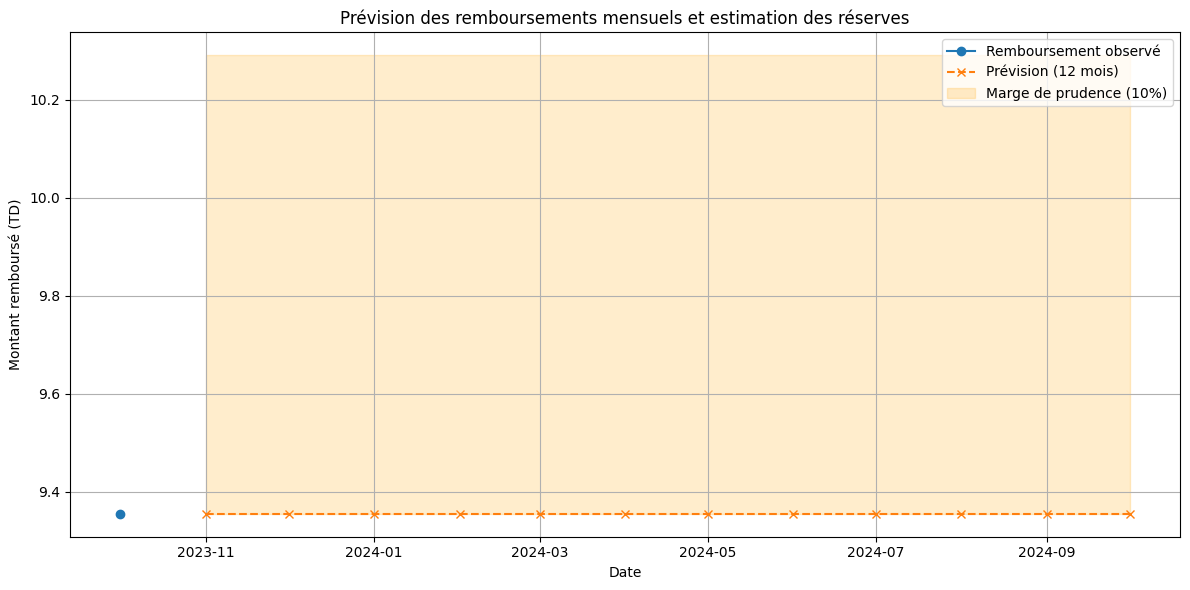


🔮 Réserve prévisionnelle (12 mois) :
 - Somme estimée : 112.26 TD
 - Avec marge de prudence (10%) : 123.49 TD


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 🗓️ Associer chaque ligne à une date de facture
date_facture = pd.to_datetime(data_facture["date_facture"])
df_tarif["date"] = date_facture

# 📅 Grouper par mois pour construire la série temporelle
df_tarif_mensuel = df_tarif.groupby(df_tarif["date"].dt.to_period("M")).agg({
    "remboursement_total": "sum"
}).reset_index()
df_tarif_mensuel["date"] = df_tarif_mensuel["date"].dt.to_timestamp()

# 📈 Préparation pour la régression linéaire
df_tarif_mensuel = df_tarif_mensuel.sort_values("date")
df_tarif_mensuel["mois_num"] = np.arange(len(df_tarif_mensuel))
X = df_tarif_mensuel[["mois_num"]]
y = df_tarif_mensuel["remboursement_total"]

# 🤖 Modèle de prédiction
model = LinearRegression()
model.fit(X, y)

# 🕐 Prédiction pour les 12 mois suivants
mois_futurs = np.arange(len(df_tarif_mensuel), len(df_tarif_mensuel) + 12)
dates_futures = pd.date_range(start=df_tarif_mensuel["date"].max() + pd.offsets.MonthBegin(1), periods=12, freq='MS')
predictions = model.predict(mois_futurs.reshape(-1, 1))

# 🛡️ Réserve estimée avec facteur de prudence
facteur_prudence = 1.1
reserve_estimee = predictions.sum()
reserve_avec_marge = reserve_estimee * facteur_prudence

# 📊 Affichage du graphique
plt.figure(figsize=(12, 6))
plt.plot(df_tarif_mensuel["date"], y, label="Remboursement observé", marker='o')
plt.plot(dates_futures, predictions, label="Prévision (12 mois)", linestyle="--", marker='x')
plt.fill_between(dates_futures, predictions, predictions * facteur_prudence, color='orange', alpha=0.2, label="Marge de prudence (10%)")
plt.title("Prévision des remboursements mensuels et estimation des réserves")
plt.xlabel("Date")
plt.ylabel("Montant remboursé (TD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📢 Résumé
print("\n🔮 Réserve prévisionnelle (12 mois) :")
print(f" - Somme estimée : {reserve_estimee:.2f} TD")
print(f" - Avec marge de prudence (10%) : {reserve_avec_marge:.2f} TD")


1. 📈 Prévision améliorée avec Prophet


Gère automatiquement les tendances + saisonnalités.

Meilleure robustesse que LinearRegression pour des séries temporelles (ex : remboursements qui montent et descendent dans l'année).

In [11]:
df_tarif["date"] = pd.to_datetime(data_facture["date_facture"], dayfirst=True)


In [13]:
#!pip uninstall -y fbprophet

#!pip install prophet

from prophet import Prophet



Arima


In [ ]:
#!pip install statsmodels


   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.9 MB 2.3 MB/s eta 0:00:05
    --------------------------------------- 0.2/9.9 MB 3.1 MB/s eta 0:00:04
   - -------------------------------------- 0.4/9.9 MB 3.0 MB/s eta 0:00:04
   -- ------------------------------------- 0.7/9.9 MB 3.9 MB/s eta 0:00:03
   ---- ----------------------------------- 1.2/9.9 MB 5.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.5/9.9 MB 5.7 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.9 MB 6.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.7/9.9 MB 4.7 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.9 MB 4.7 MB/s eta 0:00:02
   ------- -------------------------------- 1.9/9.9 MB 4.5 MB/s eta 0:00:02
   -------- ------------------------------- 2.0/9.9 MB 4.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.0/9.9 MB 4.0 MB/s eta 0:00:02
   -------- -------


[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Yassine Ben MAKTOUF\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yassine Ben MAKTOUF\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yassine Ben MAKTOUF\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yassine Ben MAKTOUF\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\states

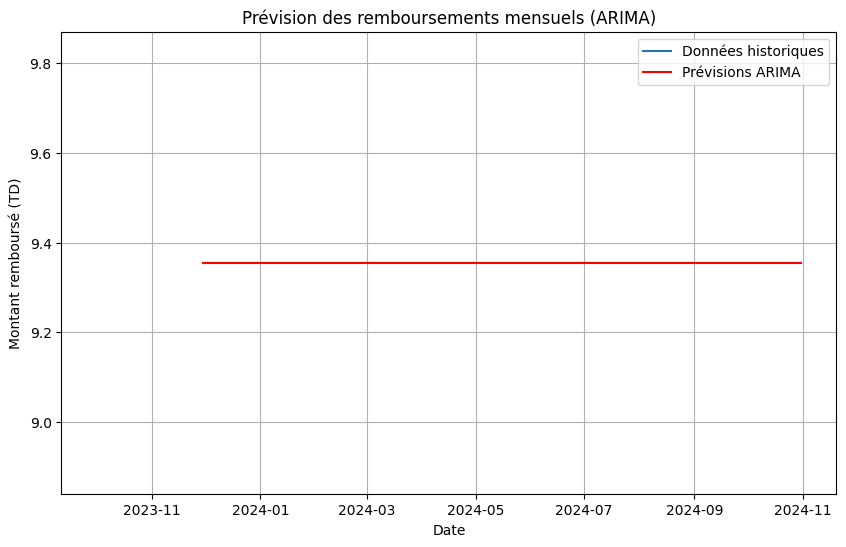


🔮 Réserve prévisionnelle (12 mois) :
 - Estimation brute : 112.26 TD
 - Avec marge de prudence (10%) : 123.49 TD


In [15]:
# 📦 Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import process
import json
from statsmodels.tsa.arima.model import ARIMA

# ================================================
# 1️⃣ Correction et Alignement des Données
# ================================================

resultats = []

# Supposons que tu as déjà ton fichier data_facture et ta base de médicaments df_meds
for med in data_facture["medicaments"]:
    nom_facture = med["nom"].strip().lower()
    quantite = med["quantite"]
    prix_unitaire = med["prix_unitaire"]
    prix_total = med["prix_total"]

    # 🎯 Fuzzy matching pour corriger les erreurs d'orthographe ou de saisie
    result = process.extractOne(nom_facture, df_meds["name"])
    if result:
        match_nom, score = result[0], result[1]
    else:
        match_nom, score = None, 0

    if score >= 85:  # Seuil de tolérance pour accepter un match
        ligne_base = df_meds[df_meds["name"] == match_nom].iloc[0]

        remboursement = float(str(ligne_base["remboursement"]).replace(",", "."))
        prix_base = float(str(ligne_base["price"]).replace(",", "."))
        montant_rembourse = remboursement * quantite

        resultat = {
            "medicament_facture": nom_facture,
            "match_base": match_nom,
            "score_match": score,
            "quantite": quantite,
            "prix_unitaire_facture": prix_unitaire,
            "prix_total_facture": prix_total,
            "prix_base": prix_base,
            "remboursement_unitaire": remboursement,
            "remboursement_total": montant_rembourse
        }
    else:
        # Si le match est trop faible
        resultat = {
            "medicament_facture": nom_facture,
            "match_base": None,
            "score_match": score,
            "quantite": quantite,
            "prix_unitaire_facture": prix_unitaire,
            "prix_total_facture": prix_total,
            "prix_base": None,
            "remboursement_unitaire": 0,
            "remboursement_total": 0
        }

    resultats.append(resultat)

# 📋 Construction du DataFrame final
df_tarif = pd.DataFrame(resultats)

# Conversion des montants en numérique
df_tarif["prix_total_facture"] = pd.to_numeric(df_tarif["prix_total_facture"], errors="coerce")
df_tarif["remboursement_total"] = pd.to_numeric(df_tarif["remboursement_total"], errors="coerce")

# ==========================
# 2️⃣ Construction de la Série Temporelle
# ==========================

# 📅 Ajouter la date de facture
df_tarif["date"] = pd.to_datetime(data_facture["date_facture"])

# 🗓️ Grouper par mois
df_tarif_mensuel = df_tarif.groupby(df_tarif["date"].dt.to_period("M")).agg({
    "remboursement_total": "sum"
}).reset_index()

df_tarif_mensuel["date"] = df_tarif_mensuel["date"].dt.to_timestamp()

# ==========================
# 3️⃣ Prévision avec ARIMA
# ==========================

# 📈 Préparer les données pour ARIMA
df_arima = df_tarif_mensuel.rename(columns={"date": "ds", "remboursement_total": "y"})
df_arima.set_index("ds", inplace=True)

# 🔮 Entraîner le modèle ARIMA
model_arima = ARIMA(df_arima["y"], order=(1, 1, 1))  # (p, d, q) - Ajuster si nécessaire
model_arima_fit = model_arima.fit()

# 🗓️ Générer les prévisions pour les 12 prochains mois
forecast = model_arima_fit.forecast(steps=12)

# 📊 Visualisation des prévisions
plt.figure(figsize=(10, 6))
plt.plot(df_arima.index, df_arima["y"], label="Données historiques")
plt.plot(pd.date_range(df_arima.index[-1], periods=13, freq='M')[1:], forecast, label="Prévisions ARIMA", color='red')
plt.title("Prévision des remboursements mensuels (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Montant remboursé (TD)")
plt.grid(True)
plt.legend()
plt.show()

# Résumer les 12 prochains mois
reserve_estimee = forecast.sum()
facteur_prudence = 1.1  # +10% de sécurité
reserve_avec_marge = reserve_estimee * facteur_prudence

print("\n🔮 Réserve prévisionnelle (12 mois) :")
print(f" - Estimation brute : {reserve_estimee:.2f} TD")
print(f" - Avec marge de prudence (10%) : {reserve_avec_marge:.2f} TD")

# ==========================
# 4️⃣ Sauvegarde des Résultats
# ==========================

# 📂 Sauvegarder les résultats détaillés
df_tarif.to_csv("detail_medicaments.csv", index=False)
df_tarif.to_json("detail_medicaments.json", orient="records", force_ascii=False, indent=2)

# 📂 Sauvegarder la série temporelle
df_tarif_mensuel.to_csv("serie_mensuelle.csv", index=False)

# 📂 Sauvegarder le résumé des réserves
resume = {
    "Reserve estimée brute (DT)": f"{reserve_estimee:,.2f}",
    "Reserve avec prudence (DT)": f"{reserve_avec_marge:,.2f}"
}

with open("resume_global.json", "w", encoding="utf-8") as f:
    json.dump(resume, f, ensure_ascii=False, indent=2)
